In [1]:
##--------------------------------------------------------------------------------
## Summary : Use Adversial noise to fool the Inception model
## Author  : Venkata Srinivas Vemprala
## SourceCode : https://github.com/vesrinivas/DeepLearning
##--------------------------------------------------------------------------------

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import InceptionModule
from IPython.display import Image, display

In [2]:
## We have written a helper function for reading the Inception model
## We will use that in this tutorial

model = InceptionModule.InceptionModule()

In [3]:
## lets get various layers of the model. This is required to compute the gradients

##Layer at which resized image is given as input. Tensorflow performs image resizing to 299x299
##We are getting this layer because we don't want resizing to effect the noise 
resized_image = model.resized_image

##layer that gets predicted output
y_pred = model.y_pred

##Logits layer which is layer before y_pred.
y_logits = model.y_logits


In [4]:
## Lets modify the inception model to learn adversial noise
## we will be using the cross entropy loss and gradient descent to learn

with model.graph.as_default():
    
    ##Lets create a placeholder for the target class
    targetClass = tf.placeholder(dtype=tf.int32)
    
    ##Lets define the loss function
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits,labels=[targetClass])
    
    ##get the gradients with respect to loss
    gradients = tf.gradients(loss,resized_image)

In [5]:
## lets start the session
session = tf.Session(graph=model.graph)

In [6]:
## lets define a function to learn the noise
def gen_adv_noise(image_path, cls_target, noise_limit=3.0,required_score=0.99, max_iterations=100):
    
    # Lets create a feed dictinary with the image
    feed_dict = model._create_feed_dict(image_path=image_path)
    
    # Get the resized image and calucate the scores
    pred, image = session.run([y_pred,resized_image],feed_dict=feed_dict)
    
    # Convert the predicted Scores to one-dimensional array
    pred = np.squeeze(pred)
    
    # Find the class that is predicted with high probability
    cls_source = np.argmax(pred)
    
    # Get the score of the class with high probability
    score_source_org = np.max(pred)
    
    # Get the names of the source and target classes
    source_class_name = model.name_lookup.cls_to_name(cls=cls_source,only_first_name=True)
    target_class_name = model.name_lookup.cls_to_name(cls=cls_target,only_first_name=True)
    
    # Lets initialize noise
    noise = 0
    
    for i in range(max_iterations):
                
        # Add adv noise to image and create the noisy image
        image_noisy = image + noise
        
        # we need to clip the image so that the image still lies with in [0,255] range
        image_noisy = np.clip(a=image_noisy,a_min=0,a_max=255)
        
        # Create a feed_dict to feed noisy image to the resized_image layer
        feed_dict = {model.tensor_name_resized_image: image_noisy,targetClass : cls_target}
        
        # feed the noisy image to the model and get the pred and gradient
        pred, grad = session.run([y_pred,gradients],feed_dict=feed_dict)
        
        # Get the scores of the source,target classes in this iteration. 
        pred = np.squeeze(pred)
        score_source = pred[cls_source]
        score_target = pred[cls_target]
        
        # Get the maximum of gradients and compute eta as 7/grad_max
        grad = np.squeeze(grad)
        grad_max = np.abs(grad.max())
        
        if grad_max<1e-10:
            grad_max = 1e-10
            
        eta = 7/grad_max
        
        # break if score of target class greater than required
        if score_target >= required_score:
            break;
        else:
            # update the noise
            noise = noise - eta*grad
            
            # make sure noise stays within bounds
            noise = np.clip(a=noise,a_min=-1*noise_limit,a_max=noise_limit)
        
        # Print the iteration statistics
        print('Iteration ',i,' :')
        print('Class ',source_class_name,' score :',score_source,' Class ',target_class_name,' score :',score_target)
        
    return image.squeeze(),image_noisy.squeeze(),noise,source_class_name,target_class_name,score_source,score_target,score_source_org

In [7]:
## As the image noise is very small it is not visible to human eye.
## To plot it we need to normalize it. We will use min_max normalization
def normalize_image(x):
    xMin = np.min(x);
    xMax = np.max(x);
    
    xNorm = (x-xMin)/(xMax-xMin)
    return xNorm;

In [8]:
## lets write a helper function to plot the images
def plotImages(image,image_noisy,noise,source_class_name,target_class_name,
               score_source,score_target,score_source_org):
    
    # Create sub-plots to plot images
    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    # Plot the original image.
    # Note that the pixel-values are normalized to the [0.0, 1.0]
    # range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow((image/255.0), interpolation=interpolation)
    msg = "Original Image:\n{0} ({1:.2%})"
    xlabel = msg.format(source_class_name, score_source_org)
    ax.set_xlabel(xlabel)

    # Plot the noisy image.
    ax = axes.flat[1]
    ax.imshow((image_noisy / 255.0), interpolation=interpolation)
    msg = "Image + Noise:\n{0} ({1:.2%})\n{2} ({3:.2%})"
    xlabel = msg.format(source_class_name, score_source, target_class_name, score_target)
    ax.set_xlabel(xlabel)

    # Plot the noise.
    # The colours are amplified otherwise they would be hard to see.
    ax = axes.flat[2]
    ax.imshow(normalize_image(noise), interpolation=interpolation)
    xlabel = "Amplified Noise"
    ax.set_xlabel(xlabel)

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
   

In [9]:
## Lets write a function which uses both the above classes
def findAdvExamples(image_path,cls_target,noise_limit,required_score):
    
    # Get adversial noise
    image,image_noisy,noise,source_class_name,target_class_name,score_source,score_target,score_source_org = gen_adv_noise(image_path=image_path, cls_target=cls_target, noise_limit=noise_limit,required_score=0.99)
    
    # plot the images
    plotImages(image=image,image_noisy=image_noisy,noise=noise,source_class_name=source_class_name,target_class_name=target_class_name,score_source=score_source,score_target=score_target,score_source_org=score_source_org)
    
    # print final noise statistics
    print('Noise statistics :')
    print('Mean : ',noise.mean(),' STD : ',noise.std())
    print('Max : ',noise.max(),' Min : ',noise.min())

Iteration  0  :
Class  giant panda  score : 0.94522  Class  golden retriever  score : 4.70066e-05
Iteration  1  :
Class  giant panda  score : 0.751543  Class  golden retriever  score : 0.000555362
Iteration  2  :
Class  giant panda  score : 0.543738  Class  golden retriever  score : 0.00180803
Iteration  3  :
Class  giant panda  score : 0.412481  Class  golden retriever  score : 0.00467503
Iteration  4  :
Class  giant panda  score : 0.0788317  Class  golden retriever  score : 0.0669642
Iteration  5  :
Class  giant panda  score : 0.000523778  Class  golden retriever  score : 0.67079
Iteration  6  :
Class  giant panda  score : 0.04884  Class  golden retriever  score : 0.669905
Iteration  7  :
Class  giant panda  score : 1.27117e-05  Class  golden retriever  score : 0.989663
Iteration  8  :
Class  giant panda  score : 0.000432136  Class  golden retriever  score : 0.979009


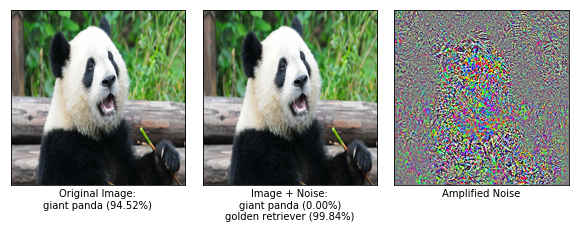

Noise statistics :
Mean :  -0.00205557  STD :  1.30929
Max :  3.0  Min :  -3.0


In [10]:
imagePath = 'inception/panda.jpg'
findAdvExamples(image_path=imagePath,cls_target=125,noise_limit=3.0,required_score=0.99)

Iteration  0  :
Class  airliner  score : 0.899654  Class  Brittany spaniel  score : 0.000110169
Iteration  1  :
Class  airliner  score : 0.722405  Class  Brittany spaniel  score : 0.000334048
Iteration  2  :
Class  airliner  score : 0.446836  Class  Brittany spaniel  score : 0.000700286
Iteration  3  :
Class  airliner  score : 0.520499  Class  Brittany spaniel  score : 0.00135806
Iteration  4  :
Class  airliner  score : 0.234004  Class  Brittany spaniel  score : 0.00731961
Iteration  5  :
Class  airliner  score : 0.0741152  Class  Brittany spaniel  score : 0.0938644
Iteration  6  :
Class  airliner  score : 0.255344  Class  Brittany spaniel  score : 0.0765556
Iteration  7  :
Class  airliner  score : 0.0127027  Class  Brittany spaniel  score : 0.494596
Iteration  8  :
Class  airliner  score : 0.280459  Class  Brittany spaniel  score : 0.0373096
Iteration  9  :
Class  airliner  score : 0.00583096  Class  Brittany spaniel  score : 0.672121
Iteration  10  :
Class  airliner  score : 0.256437

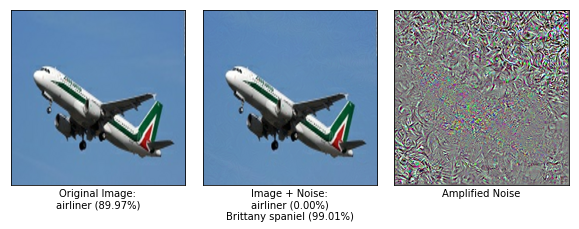

Noise statistics :
Mean :  -0.00229204  STD :  1.03445
Max :  3.0  Min :  -3.0


In [11]:
imagePath = 'inception/plane.jpg'
findAdvExamples(image_path=imagePath,cls_target=150,noise_limit=3.0,required_score=0.99)